In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import os
import scipy
from scipy import integrate
import mpld3

In [44]:
import sys
 
def findClosest(arr, n, target):
    left, right = 0, n - 1
    while left < right:
        if abs(arr[left] - target) <= abs(arr[right] - target):
            right -= 1
        else:
            left += 1
    return arr[left]

def flam_to_fnu(wav, flux_lam):
    return wav**2 * 1e-18 * (1/3) * flux_lam*1e-19

def fnu_to_abmag(flux_nu):
    return np.nan_to_num((-2.5 * np.log10(f_nu)) - 48.6)

(1202,)
(1202,)
[0.223042 0.216337 0.210922 ... 0.200117 0.199099 0.194513]


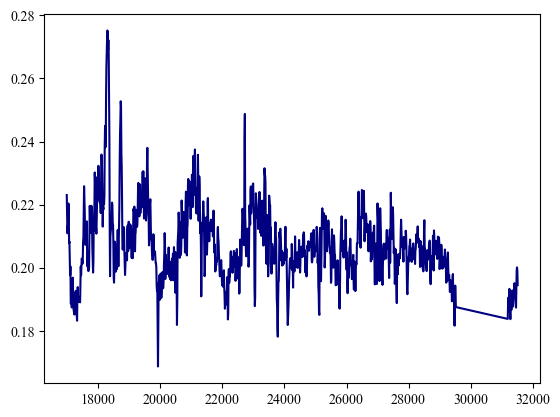

In [51]:
path = '/Users/neelsharma/Desktop/ASTRProjects/NIRSpec/wenlei_spec_4446_v3.0/l3c_4446001001_03103_s00002_00007_x1d_optimal_flam.dat'

file = open(path, 'r')
wavs = []
flux_lam = []

#for line in file:
#    line_list = []
#    line_list = line.strip().split(' ')
#    wavs.append(float(line_list[0]))
#    flux_lam.append(float(line_list[2]))

plotting = np.loadtxt(path)

mask = (plotting[:,1] > 0)

wavs = plotting[mask,0]
flux_lam = plotting[mask,1]
flux_error_lam = plotting[mask,2]

#print(len(plotting),plotting.shape)

print(wavs.shape)
print(flux_lam.shape)

print(flux_lam)

#print(wavs)
#print(flux_lam) #10^-21.0 erg s^-1 cm^-2 A^-1

fig, ax = plt.subplots()

ax.plot(wavs, flux_lam, drawstyle='default', color='navy')

#lambda, map, itertools, data classes, astropy table, pandas

In [46]:
f_nu = flam_to_fnu(wavs, flux_lam)
ab_mag = fnu_to_abmag(f_nu)

print('\nWavelength')
print(wavs)

print('F𝜈:') #10^-29.0 erg s^-1 cm^-2 Hz^-1
print(f_nu)

print('\nAB Mag:') #Mag
print(ab_mag)


Wavelength
[16988.360463 16999.069958 17009.779449 ... 31484.285905 31494.956564
 31505.627176]
F𝜈:
[-4.71002366e-32  2.14840284e-30  2.08644487e-30 ...  6.61226764e-30
  6.58309089e-30  6.43581625e-30]

AB Mag:
[ 0.         25.5697107  25.60148272 ... 24.34912394 24.35392537
 24.37849091]


/var/folders/qy/trts8c7d3dg4b7k01x7trmlw0000gn/T/ipykernel_31638/559892248.py:17: RuntimeWarning: invalid value encountered in log10
  return np.nan_to_num((-2.5 * np.log10(f_nu)) - 48.6)


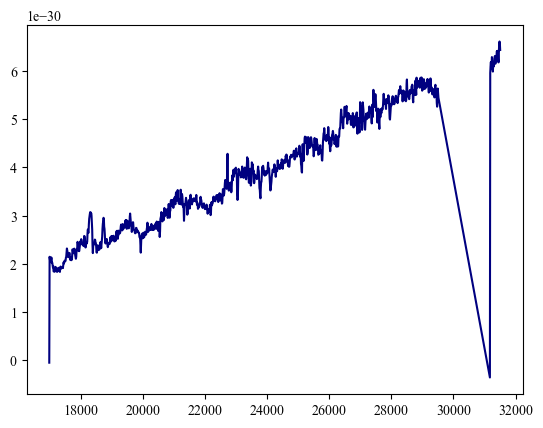

In [47]:
fig, ax = plt.subplots()

ax.plot(wavs, f_nu, drawstyle='default', color='navy')

ValueError: operands could not be broadcast together with shapes (1,803) (804,0) 

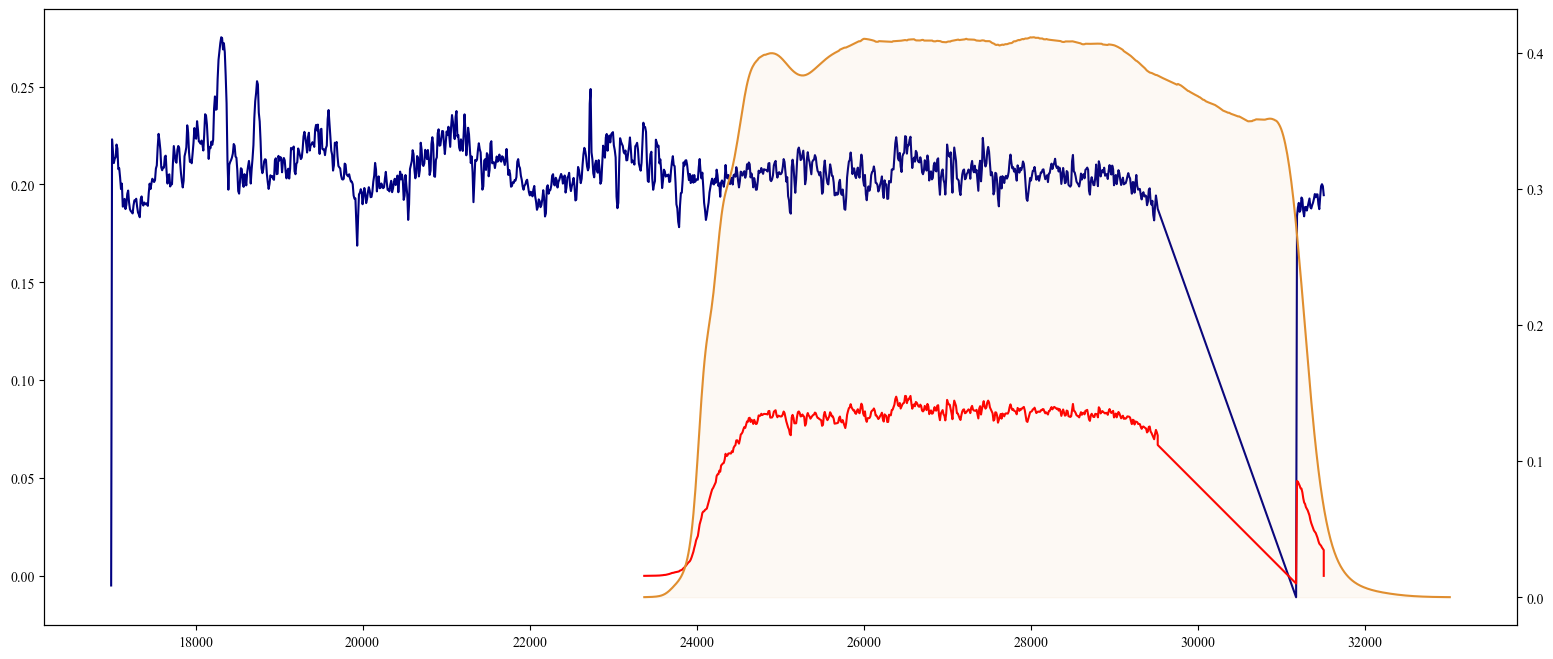

In [48]:
fig, ax = plt.subplots(figsize=(19,8))

flux = flux_lam

plt.xscale('linear')
plt.yscale('linear')

Con, = ax.plot(wavs, flux, drawstyle='default', color='navy', label='Arc 2c Continuum Spectrum')

# FILTER PLOTTING

filters = '''   JWST_NIRCam.F090W.dat
                JWST_NIRCam.F115W.dat
                JWST_NIRCam.F150W.dat
                JWST_NIRCam.F200W.dat
                JWST_NIRCam.F277W.dat
                JWST_NIRCam.F356W.dat
                JWST_NIRCam.F444W.dat
                JWST_NIRCam.F410M.dat
'''

pivotwavsdict = {'JWST_NIRCam.F090W.dat' : 0.901,
                'JWST_NIRCam.F115W.dat' : 1.154,
                'JWST_NIRCam.F150W.dat' : 1.501,
                'JWST_NIRCam.F200W.dat' : 1.990,
                'JWST_NIRCam.F277W.dat' : 2.786,
                'JWST_NIRCam.F356W.dat' : 3.563,
                'JWST_NIRCam.F444W.dat' : 4.421,
                'JWST_NIRCam.F410M.dat' : 4.092}

ax2 = ax.twinx()

for filename in os.listdir('filters/'):
    if filename in filters:
        file = open('filters/'+filename, 'r')

        wavsrange = []
        through = []

        for line in file:
            pair = line.strip().split(' ')
            wavsrange.append(float(pair[0]))
            through.append(float(pair[1]))
        
        Filt, = ax2.plot(wavsrange, through, color='#E08E2F', label='Filter Transmission Curve')
        ax2.fill_between(wavsrange, through, color='#E08E2F', alpha=0.05)

        # FILTER INTEGRATION

        filt_flux = []
        filt_range = []
        main_flux = []
        diff = []

        if filename in pivotwavsdict:
            pivwav = pivotwavsdict[filename] * 10000

        for n in range(0, len(wavsrange), 1):

            closestwav = findClosest(wavs, len(wavs), wavsrange[n]) # closest value in wavs to wavsrange[n] is closestwav

            mag = through[n] * flux_lam[np.where(wavs == closestwav)]

            diff.append(flux_lam[np.where(wavs == closestwav)] - mag)

            filt_range.append(closestwav)
            filt_flux.append(mag)
            
            main_flux.append(flux_lam[np.where(wavs == closestwav)])

        filter_integ = sum(filt_flux)
        main_integ = sum(main_flux)

        Integ, = ax.plot(filt_range, filt_flux, color='red', label='Filter Considered Spectra')

        integrated_fluxlam = scipy.integrate.trapezoid(filt_flux, filt_range)/scipy.integrate.trapezoid(through, filt_range)
        integrated_main_flux = scipy.integrate.trapezoid(main_flux, filt_range)
        integrated_filter_flux = scipy.integrate.trapezoid(filt_flux, filt_range)
        integrated_throughput = scipy.integrate.trapezoid(through, filt_range)
        integrated_fluxnu =  (pivwav**2) * (2.99e-18) * integrated_fluxlam
        integrated_fluxAB = -2.5 * np.log10(integrated_fluxnu) - 46.8

        

        #print('\nFilename: \t\t' + filename)
        #print('IntegrationLam: \t' + str(integrated_fluxlam))
        #print('IntegrationAB: \t\t' + str(integrated_fluxAB))
        #print(integrated_main_flux)
        #print(integrated_filter_flux)
        #print(integrated_throughput)


ax2.set_ylabel('Throughput', fontsize=22)

ax2.set_ylim(0, 1)
ax2.set_xlim(16800, 32000)

ax.set_xlabel('Wavelength (Å)', fontsize=22)
ax.set_ylabel('Flux (λ)', fontsize=22)

ax.set_ylim(0, 0.010) #(22.6, 25.4)
ax.set_xlim(5000, 50000)

# TICK ADJUSTMENTS

ax.minorticks_on()
ax.tick_params(labelsize=22)
ax2.minorticks_on()
ax2.tick_params(labelsize=22)
plt.rcParams.update({'font.serif': "Times New Roman",
                     'font.family': "serif"                  
                    })

ax.legend(handles=[Con, Integ, Filt], loc='upper right', prop={'family': 'Times New Roman', 'size': '20'})
plt.title('Synthetic Astronomy Exploration w/ Arc 2c', fontsize=30)
plt.show()

#try ab first then try ab later, compare

In [110]:
new_lam = []
for i in range(0, len(flux_lam), 1):
    new_lam.append(flux_lam[i] * 1e-17)

np.mean(new_lam)

3.8204692691029904e-20

In [ ]:
for filename in os.listdir('filters/'):
    if filename in filters:
        file = open('filters/'+filename, 'r')

        wavsrange = []
        through = []

        for line in file:
            pair = line.strip().split(' ')
            wavsrange.append(float(pair[0]))
            through.append(float(pair[1]))

        wavelength = wavsrange[-1]
        filt_flux[filt_range.index(wavelength)]

scipy.integrate.trapz(flux1_trans_corr_lamda, wave1_trans_corr)/scipy.integrate.trapz(trans_lamda, wave1_trans_corr)